B-Store can compute statistics describing localizations that have been spatially clustered. Some commonly desired statistics are the cluster's center-of-mass and the number of localizations in the cluster. By default, B-Store computes 

1. the cluster center of mass
2. the number of localizations
3. the radius of gyration of the cluster
4. the eccentricity of the cluster
5. the cluster's convex hull (only if pyhull is installed)

Besides these built-in statistics, B-Store allows the user to define their own functions for computing cluster statistics. This example shows how to do this.

In [1]:
%pylab inline
from bstore import processors as proc
from pathlib import Path
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Load the test data
The test data for this example is in the [B-Store test files repository](https://github.com/kmdouglass/bstore_test_files). Download or clone this repository, and set the variable below to point to */processor_test_files/test_cluster_stats.csv*

In [2]:
pathToData = Path('../../bstore_test_files/processor_test_files/test_cluster_stats.csv')

with open(str(pathToData), mode = 'r') as file:
    df = pd.read_csv(file)

In [3]:
df

,x [nm],y [nm],frame,z [nm],uncertainty [nm],intensity [photon],offset [photon],loglikelihood,sigma [nm],cluster_id
0,-0.5,-0.5,0.0,0.0,10.021870,939.780732,80.219038,161.494040,155.721151,0
1,-0.5,0.5,0.0,0.0,9.408785,823.403821,95.393895,209.190424,144.446742,0
2,0.5,-0.5,0.0,0.0,10.333715,952.012166,98.656850,243.701264,94.320590,0
3,0.5,0.5,0.0,0.0,10.626735,1199.351397,88.166699,218.270532,132.115268,0
4,0.0,0.0,0.0,0.0,9.765064,955.466949,96.280657,214.759480,117.792403,0
5,8.0,1.0,0.0,0.0,9.876863,1078.617481,104.159719,159.946843,135.698560,1
6,8.0,3.0,0.0,0.0,12.155545,989.443663,89.928289,147.019781,155.021342,1
7,12.0,1.0,0.0,0.0,10.104455,1034.073165,106.581499,201.612959,126.016791,1
8,12.0,3.0,0.0,0.0,8.893435,1050.715863,91.599433,199.450961,122.429116,1
9,10.0,2.0,0.0,0.0,10.755980,1105.557538,100.467041,162.443624,151.329622,1


The test dataset has 10 localizations and two clusters. The clusters are identified by `0` and `1` in the `cluster_id` column. Let's go ahead and visualize these localizations.

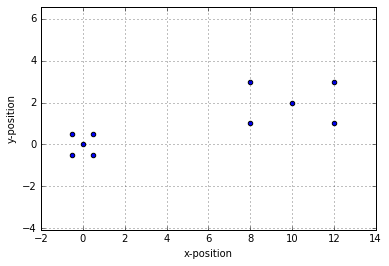

In [4]:
plt.scatter(df['x [nm]'], df['y [nm]'])
plt.xlabel('x-position')
plt.ylabel('y-position')
plt.axis('equal')
plt.grid(True)
plt.show()

# Compute the default statistics
Before customizing the behavior of the `ComputeClusterStats` processor, let's see how its default behavior works. First, we define the processor and tell it which columns to use as localization coordinates (by default it uses `['x', 'y']`) and which column to use as the cluster label (by default it uses `cluster_id`).

In [5]:
# We don't need to set idLabel; the default value of 'cluster_id' is fine.
statProc = proc.ComputeClusterStats(coordCols = ['x [nm]', 'y [nm]'])

In [6]:
# Apply the processor to the test data
statProc(df)

,cluster_id,x [nm]_center,y [nm]_center,number_of_localizations,radius_of_gyration,eccentricity,convex_hull
0,0,0.0,0.0,5,0.632456,1.0,1.0
1,1,10.0,2.0,5,2.000000,4.0,8.0


As you can see, `ComputeClusterStats` outputs the clusters' centers of mass, number of localizations, radius of gyration, and eccentricity by default. (You will also see the convex hull if [pyhull](https://pythonhosted.org/pyhull/) is installed.)

# Computing customized clustered statistics
What if you want to compute some custom statistics from your clusters?

This is possible by writing a function that operates on the coordinates of each localization and produces a single number for each cluster. This function is then given a name and fed to `ComputeClusterStats`'s constructor. Everytime your new `ComputeClusterStats` object is executed, you will receive your custom statistic.

For example, let's say that you need to know a statistic for each cluster that can be computed by multiplying the coordinate values of each localization by two, taking the variance of the results, and then summing the variances. We can write a function do this like so:

In [7]:
def VarTimesTwo(group, coordinates):
        # Multiples each localization position by 2, then computes
        # the sum of the variances. This is a bit silly but serves
        # as a good example.
        variances = group[coordinates].apply(lambda x: x * 2).var(ddof=0)
        return variances.sum()

Maybe we also care to know a statistic where the multiplication is by 3 instead of two:

In [8]:
def VarTimesThree(group, coordinates):
        # Multiples each localization position by 3, then computes
        # the sum of the variances.
        variances = group[coordinates].apply(lambda x: x * 3).var(ddof=0)
        return variances.sum()

Each custom function you write should take two arguments: `group` and `coordinates`. The `group` argument is a Python [Pandas GroupBy](http://pandas.pydata.org/pandas-docs/stable/groupby.html) object. Essentially, this represents DataFrames that only contain rows where the `cluster_id` value is equal. The `coordinates` column will hold the names of the x and y-coordinates that you supplied to the `ComputeClusterStats`'s `coordCols` argument.

For the purpose of this example, I wouldn't worry about the details of what each function is doing. The important thing here is that you can do whatever operation you want to on the coordinate columns for each cluster, so long as the function that does so returns a single number that's computed from the coordinates.

Now, we place each function into a [dictionary](https://docs.python.org/3.5/library/stdtypes.html#mapping-types-dict) whose keys will represent the names of the new columns and whose values are the functions we just created. This dictionary is passed to the `statsFunctions` argument of a new `ComputeClusterStats` object.

In [9]:
# Add the two new functions to a dictionary.
# 'var times two' and 'three var' will be the
# names of the columns containing the cluster
# statistics
customStats = {'var times two' : VarTimesTwo,
               'three var'     : VarTimesThree}

# Create the new processor
newStatsProc = proc.ComputeClusterStats(coordCols = ['x [nm]', 'y [nm]'],
                                        statsFunctions= customStats)

# Compute the statistics
newStatsProc(df)

,cluster_id,x [nm]_center,y [nm]_center,number_of_localizations,radius_of_gyration,eccentricity,var times two,convex_hull,three var
0,0,0.0,0.0,5,0.632456,1.0,1.6,1.0,3.6
1,1,10.0,2.0,5,2.000000,4.0,16.0,8.0,36.0


This returns a DataFrame containing two new columns matching the names we set in the dictionary.

# Summary
+ `ComputeClusterStats` combines localizations with the same cluster ID's and computes a single number from the localizations' coordinates
+ Custom statistics may be computed by adding a dictionary of functions to `ComputeClusterStats`'s constructor
+ The keys of the dictionary define the column names; the values hold the functions
+ Each custom function requires a `group` and `coordinates` argument